In [1]:
import os
import random 

!pip install pydot
!pip install graphviz
!pip install -q mlflow
!pip install tqdm
!pip install tensorflow_addons
!pip install geopandas
!pip install rasterio
!pip install geopandas fiona
!pip install sklearn

import cv2
import random
import tensorflow as tf
import tensorflow.keras
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import rasterio
import rasterio.features
import fiona
import geopandas as gpd
import rasterio
import rasterio.features
import math
import mlflow
import mlflow.tensorflow

from keras.utils.vis_utils import plot_model
from tqdm import tqdm
from rasterio.features import geometry_mask, rasterize
from rasterio.transform import Affine, from_origin
from PIL import Image, ImageDraw
from pyproj import Transformer
from shapely.geometry import shape, box
from rasterio.features import geometry_mask, rasterize
from rasterio.transform import Affine, from_origin
from PIL import Image, ImageDraw
from pyproj import Transformer
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 49.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 64.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 87.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 23.4 MB/s eta 0:00:00
  Attempting uninstall: attrs
    Found existing installation: attrs 18.2.0
    Uninstalling attrs-18.2.0:
      Successfully uninstalled attrs-18.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradient 2.0.6 requires attrs<=19, but you have attrs 23.1.0 which is incompa

# **Data prepeartion from building.shp and simplified.shp**

In [11]:
class BuildingsDataset(tf.keras.utils.Sequence):
    def __init__(self, shape_path_original, shape_path_generalized, img_size=(128, 128), batch_size=4500):
        self.shape_path_original = shape_path_original
        self.shape_path_generalized = shape_path_generalized

        self.batch_size = batch_size
        self.img_size = img_size
    
        self.gdf_original = gpd.read_file(self.shape_path_original)
        self.gdf_generalized = gpd.read_file(self.shape_path_generalized)
    
    def __len__(self):
        return math.ceil(len(self.gdf_original) / self.batch_size)

    def image_from_geometry(self, geom):
        bounds = geom.bounds # (minx, miny, maxx, maxy)

        # Calculate the current width and height of the building
        width = bounds[2] - bounds[0]
        height = bounds[3] - bounds[1]

        # Calculate the desired width and height of the building (e.g., 50% of the original size)
        desired_width = width * 1.5
        desired_height = height * 1.5

        # Calculate the adjustment needed to center the building in the image
        dx = (width - desired_width) / 2
        dy = (height - desired_height) / 2

        # Adjust the bounds of the building's footprint
        new_bounds = (
            bounds[0] + dx,
            bounds[1] + dy,
            bounds[2] - dx,
            bounds[3] - dy
        )

        transform = from_origin(new_bounds[0], new_bounds[3], (new_bounds[2] - new_bounds[0]) / self.img_size[0], (new_bounds[3] - new_bounds[1]) / self.img_size[1])

        # Create a new binary image of size 128x128 pixels
        shapes = [(geom, 255)]
        img_array = rasterize(shapes, out_shape=self.img_size, transform=transform)

        return img_array
    
    def __getitem__(self, idx):
        low = idx * self.batch_size
        # Cap upper bound at array length; the last batch may be smaller
        # if the total number of items is not a multiple of batch size.
        high = min(low + self.batch_size, len(self.gdf_original))
        batch_x = self.gdf_original[low:high]['geometry']
        batch_y = self.gdf_generalized[low:high]['geometry']

        return (
            [self.image_from_geometry(geom_orig) for geom_orig in batch_x], 
            [self.image_from_geometry(geom_gen) for geom_gen in batch_y]
        )
    

In [ ]:
dataset = BuildingsDataset('data/buildings.shp', 'data/simplified.shp')
data = random.sample(list(dataset), 1)[0]

!mkdir data4k
!mkdir data4k/training
!mkdir data4k/testing
!mkdir data4k/training/image
!mkdir data4k/training/mask
!mkdir data4k/testing/image
!mkdir data4k/testing/mask

for i in range(dataset.batch_size):
    
    if (i < 4000):
        outfile1 = 'data4k/training/image/%s.png' % (i + 1)
        outfile2 = 'data4k/training/mask/%s.png' % (i + 1)
        a = data[0][i]
        b = data[1][i]
        img.imsave(outfile1,a,cmap='gray')
        img.imsave(outfile2,b,cmap='gray')
    

    else:
        outfile5 = 'data4k/testing/image/%s.png' % (i- 3999)
        outfile6 = 'data4k/testing/mask/%s.png' % (i - 3999)
        a = data[0][i]
        b = data[1][i]
        img.imsave(outfile5,a,cmap='gray')
        img.imsave(outfile6,b,cmap='gray')
    

# **Reading the Data**

In [2]:
image_path_train = 'data4k/training/image'
mask_path_train = 'data4k/training/mask'
image_path_test = 'data4k/testing/image'

In [3]:
images = os.listdir(image_path_train)
mask = os.listdir(mask_path_train)

def getData(X_shape):
    im_array = []
    mask_array = []
    shape = (X_shape, X_shape)

    for i in tqdm(images):
        if i.endswith('png'):
            im = cv2.imread(os.path.join(image_path_train, i), cv2.IMREAD_GRAYSCALE)
            im = cv2.resize(im, shape)
            im = cv2.equalizeHist(im)
            mask = cv2.imread(os.path.join(mask_path_train, i), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, shape)
       
            im_array.append(im)
            mask_array.append(mask)
    
    # return list
    return im_array, mask_array

In [4]:
def get_test(X_shape, n_samples = 100):
    im_array = []
    shape = (X_shape, X_shape)
    test_files = random.choices(list(os.listdir(image_path_test)), k=n_samples)
    for i in tqdm(test_files):
        if i.endswith('png'):
            im = cv2.imread(os.path.join(image_path_test, i), cv2.IMREAD_GRAYSCALE)
            im = cv2.resize(im, shape)
            im = cv2.equalizeHist(im)
            im_array.append(im)
    return im_array

In [5]:
dim, n_samples = 256, 500 

images, masks = getData(dim)
X_test = get_test(dim, n_samples = n_samples)




100%|██████████| 500/500 [00:00<00:00, 510.36it/s]


In [6]:
images = np.array(images).reshape(len(images), dim, dim, 1)
masks= np.array(masks).reshape(len(masks), dim, dim, 1)

In [7]:
X_test = np.array(X_test).reshape(len(X_test), dim, dim, 1)

print(images.shape, masks.shape)
print(X_test.shape)

(4000, 256, 256, 1) (4000, 256, 256, 1)
(500, 256, 256, 1)


# **Visualise the Data**

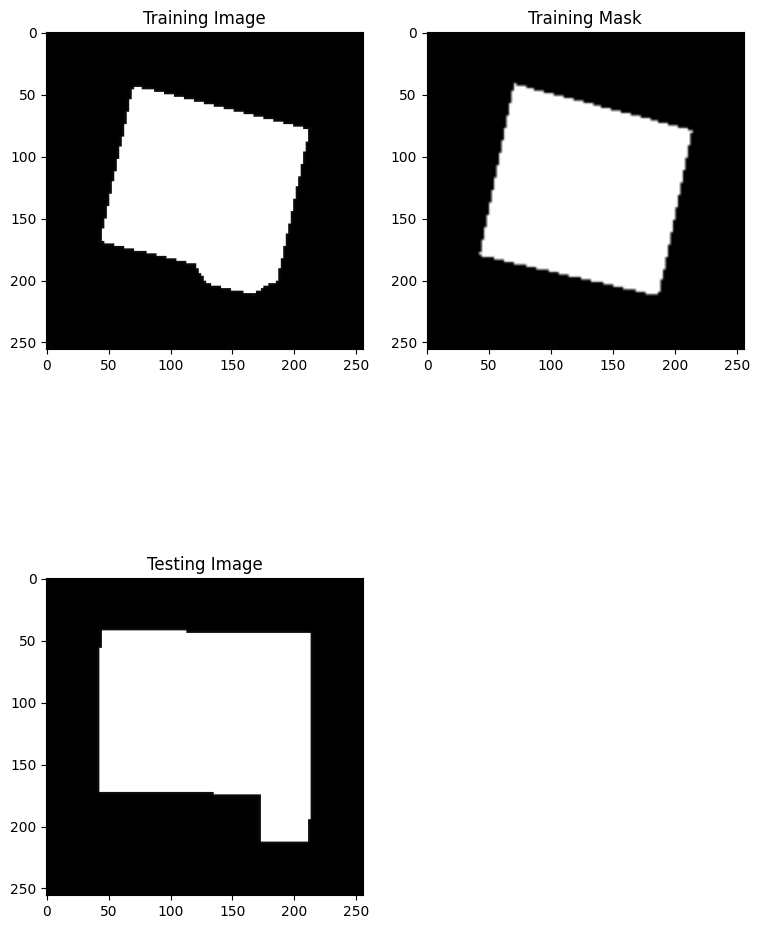

In [8]:
i = 200
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 13))
axs[0, 0].imshow(images[i].reshape(256, 256), cmap='gray')
axs[0, 1].imshow(masks[i].reshape(256, 256), cmap='gray')
axs[1, 0].imshow(X_test[i].reshape(256, 256), cmap='gray')

axs[0, 0].set_title('Training Image')
axs[0, 1].set_title('Training Mask')
axs[1, 0].set_title('Testing Image')


fig.delaxes(axs[1, 1])

In [9]:

from sklearn.model_selection  import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split((images - 127.0) / 127.0, 
                                                  (masks > 127).astype(np.float32), 
                                                  test_size = 0.2, 
                                                  random_state = 2018)
X_testNorm = (X_test - 127.0) / 127.0

# **U-Net**

In [10]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jaccard_coef_loss(y_true, y_pred):
    return 1 - jaccard_coef(y_true, y_pred) 

In [11]:
metrics = [dice_coef, jaccard_coef,
           'binary_accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall()]

loss = [dice_coef_loss, 
        jaccard_coef_loss,
        'binary_crossentropy']

In [12]:
def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [13]:
metrics = [dice_coef, jaccard_coef,
           'binary_accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall()]

loss = [dice_coef_loss, 
        jaccard_coef_loss,
        'binary_crossentropy']



# **Model Summary**

In [14]:
model = unet(input_size=(dim, dim, 1))
model.compile(optimizer = Adam(), 
              loss = loss, 
              metrics = metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [15]:

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [16]:

weight_path="{}_unet.best.h5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=4, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=35) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [17]:
#initialize random seeds so results are repeatable

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

# **Training The Model**

In [18]:
res = model.fit(X_train, Y_train, 
                validation_data=(X_val, Y_val), 
                batch_size=16, epochs=80,
                callbacks=callbacks_list)

2023-07-16 19:09:50.221599: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 838860800 exceeds 10% of free system memory.
2023-07-16 19:09:51.026447: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 838860800 exceeds 10% of free system memory.
2023-07-16 19:09:51.859223: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 838860800 exceeds 10% of free system memory.
2023-07-16 19:09:52.388710: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 838860800 exceeds 10% of free system memory.


Epoch 1/80
200/200 [==============================] - ETA: 0s - loss: 0.1072 - dice_coef: 0.8928 - jaccard_coef: 0.8173 - binary_accuracy: 0.9474 - precision_1: 0.9183 - recall_1: 0.8965
Epoch 1: val_loss improved from inf to 0.08524, saving model to cxr_reg_unet.best.h5
200/200 [==============================] - 38s 143ms/step - loss: 0.1072 - dice_coef: 0.8928 - jaccard_coef: 0.8173 - binary_accuracy: 0.9474 - precision_1: 0.9183 - recall_1: 0.8965 - val_loss: 0.0852 - val_dice_coef: 0.9148 - val_jaccard_coef: 0.8433 - val_binary_accuracy: 0.9517 - val_precision_1: 0.9293 - val_recall_1: 0.9010 - lr: 0.0010
Epoch 2/80
200/200 [==============================] - ETA: 0s - loss: 0.0829 - dice_coef: 0.9171 - jaccard_coef: 0.8471 - binary_accuracy: 0.9532 - precision_1: 0.9331 - recall_1: 0.9018
Epoch 2: val_loss improved from 0.08524 to 0.08503, saving model to cxr_reg_unet.best.h5
200/200 [==============================] - 28s 139ms/step - loss: 0.0829 - dice_coef: 0.9171 - jaccard_coef

# **Plot Training Response**

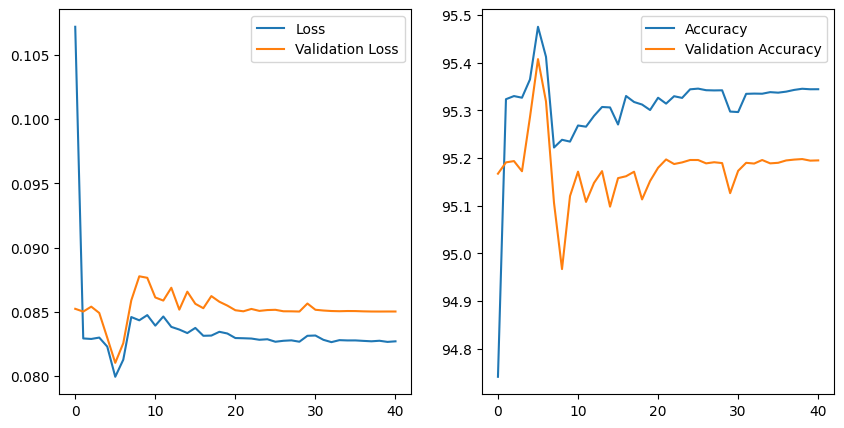

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(res.history['loss'], '-', label = 'Loss')
ax1.plot(res.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100 * np.array(res.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100 * np.array(res.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend();

# **Prediction on Validation Dataset**

In [20]:
preds_val = model.predict(X_val)

25/25 [==============================] - 3s 79ms/step


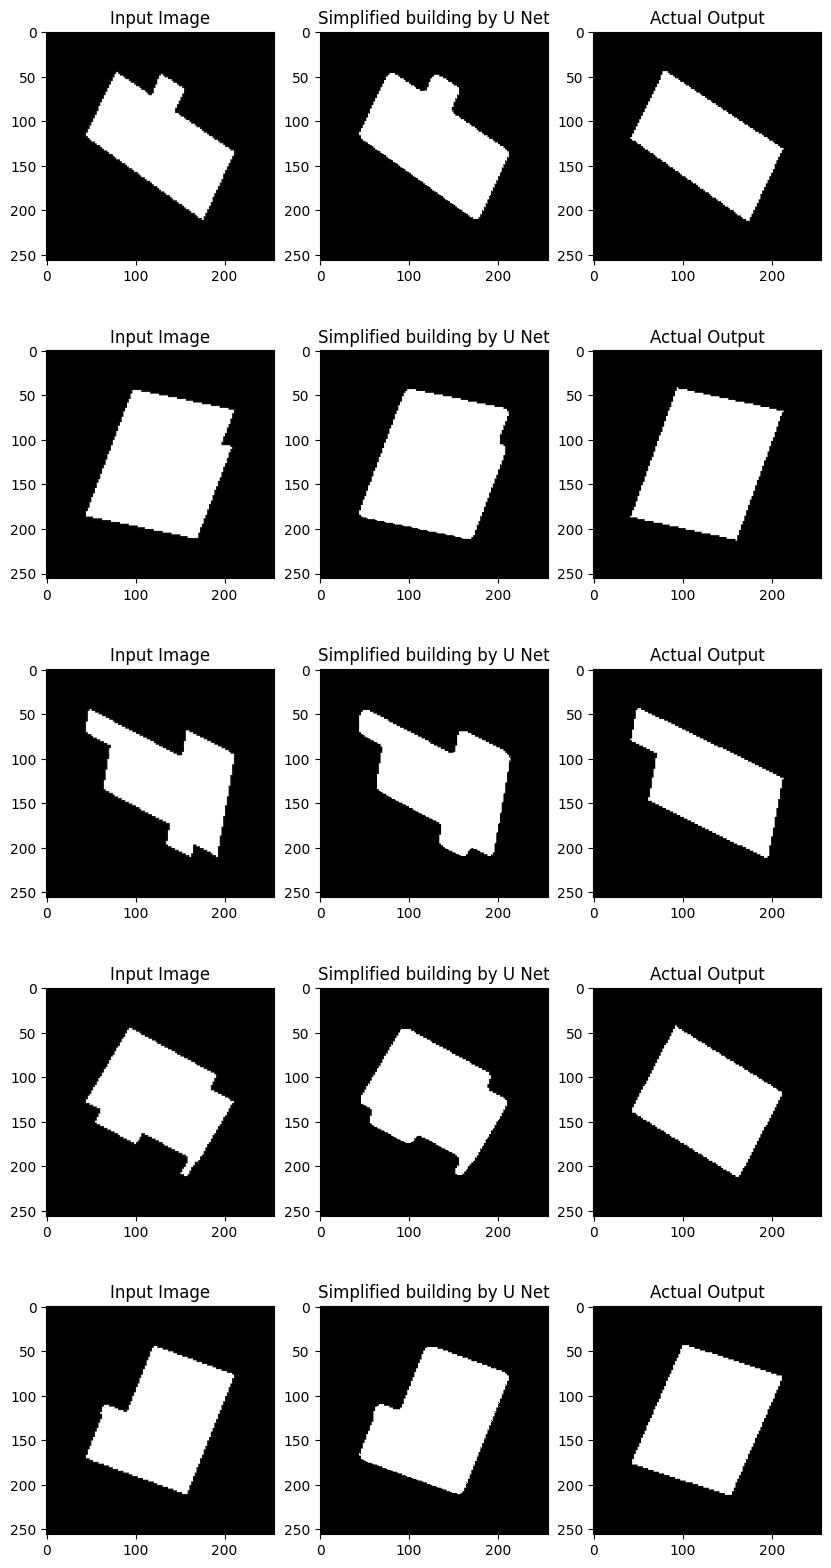

In [21]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(10, 20))

for i in range(5):
    for j in range(3):
        if j == 0:
            axs[i, j].imshow(X_val[i + 10].reshape(256, 256), cmap='gray')
            axs[i, j].set_title('Input Image')
        elif j == 1:
            axs[i, j].imshow(preds_val[i + 10].reshape(256, 256), cmap='gray')
            axs[i, j].set_title('Simplified building by U Net')
       
        elif j == 2:
            axs[i, j].imshow(Y_val[i + 10].reshape(256, 256), cmap='gray')
            axs[i, j].set_title('Actual Output')

# **Prediction on Testing Dataset**

In [22]:
preds = model.predict(X_testNorm)

16/16 [==============================] - 3s 157ms/step


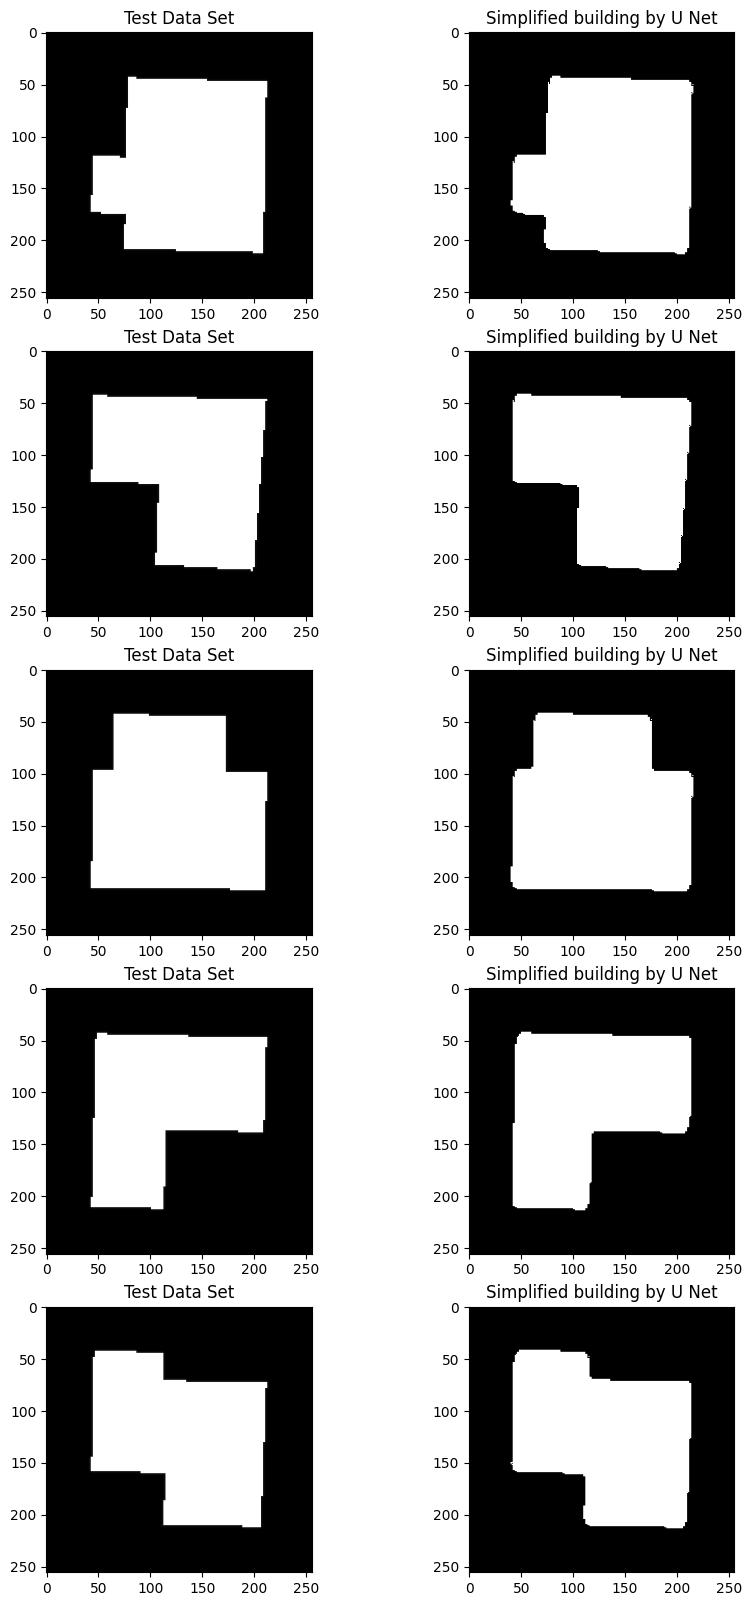

In [23]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for i in range(5):
    for j in range(2):
        if j != 1:
            axs[i, j].imshow(X_testNorm[i + 10].reshape(256, 256), cmap='gray')
            axs[i, j].set_title('Test Data Set')
        else:
            axs[i, j].imshow(preds[i + 10].reshape(256, 256), cmap='gray')
            axs[i, j].set_title('Simplified building by U Net')

# **Save the Model**


In [24]:
!mkdir -p unet_4k_dataset_model

In [25]:
model.save('unet_4k_dataset_model/unet')

INFO:tensorflow:Assets written to: unet_4k_dataset_model/unet/assets


INFO:tensorflow:Assets written to: unet_4k_dataset_model/unet/assets


In [26]:
model.save_weights('unet_4k_dataset_model/my_model_weights.h5')